In [1]:
'''
Bulk Analysis

This script runs the energy/timestamp analysis over the whole data set.
Output is saved in the format expected by resultFile class
'''
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
import os #used for file operations
import pickle #used for saving temporary results

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [3]:
#first define a bunch of commonly used functions
#this adjusts the waveform to have a 0 baseline and whatnot
def baselineShift(wave, window):
    #flip the waveform over
    wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave):
    height = None
    threshold = None
    distance = 500
    prominence = 50
    width = 100
    wlen = None
    rel_height = 0.5
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames

def getAllFileNames(path):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.bin' in file:
                files.append(os.path.join(r, file))
    files.sort()
    return files

#this function finds the energy from one peak in the waveform
def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

        

#this function finds the energy from multiple peaks by calling the above function
def energyExtractionWave(wave, peaks, rise, top, threshold):
    energies = []
    for peak in peaks:
        energy = energyExtractionPeak(wave, peak, rise, top, threshold)
        energies.append(energy)
    return energies

def perWaveAnalysis(wave):
    enerRise = 500
    enerTop = 100
    enerTau = 110
    t0Rise = 500
    t0Top = 1
    t0Tau = 110
    enerThreshold = 0.8
    #do the baseline shift
    cleanwave = baselineShift(wave, 10000)
    #use this to identify the peaks we care about
    shortTrappedWave = trapezoidalFilter(cleanwave, t0Rise, t0Top, t0Tau)
    #now actually find the peaks
    peaks = findPeaks(shortTrappedWave)
    #an approximate value for the decay rate is used here, can/should be updated
    longTrappedWave = trapezoidalFilter(cleanwave, enerRise, enerTop, enerTau) 
    energies = longTrappedWave[peaks]
    results = []
    for i in range(len(energies)):
        results.append([peaks[i]-t0Rise, energies[i]])
    return results 

In [34]:
#grab every file that will be analyzed
fileDir = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/'
files = getAllFileNames(fileDir)
pixelList = [i for i in range(16)]

In [35]:
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    for file in files:
        data = df.dataFile(file)
        print(file,files.index(file), len(files))
        nameNoExt, ext = os.path.splitext(file)
        outputFileName = nameNoExt+'.res'
        fileRes = []
        for p in range(len(pixelList)):
            waves = data.getPixel(pixelList[p])
            results = pool.map(perWaveAnalysis, [wave for wave in waves])
            fileRes.append(results)
        with open(outputFileName, 'wb') as filehandle:
            # store the data as binary data stream
            pickle.dump(fileRes, filehandle)
        

/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45210.bin 0 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45211.bin 1 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45212.bin 2 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45213.bin 3 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45214.bin 4 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45215.bin 5 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45216.bin 6 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45217.bin 7 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector12/run45218.bin 8 28
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/Co-60/Co60-Detector1

In [36]:
#now go through and grab all of the result files and grab from memory
def list_files(directory, extension):
    return [directory + f for f in os.listdir(directory) if f.endswith('.' + extension)]

resultFiles = list_files(fileDir, 'res')

In [37]:
#now load these into memory
results = [] #the external list, first index is over file, second index over pixel, third each events results
for file in resultFiles:
    with open(file, "rb") as f:
        results.append(pickle.load(f))

In [38]:
hists = []
enerHistBins = np.arange(0,400)
for pixel in pixelList:
    thisPixel = []
    for res in results: #iterate over each result
        pixelRes = res[pixel] #grab the right pixel
        for wave in pixelRes: #iterate over each waveform
            for a in wave:
                if a != []:
                    thisPixel.append(a[1])
    hist, bins = np.histogram(thisPixel, bins = enerHistBins)
    hists.append(hist)

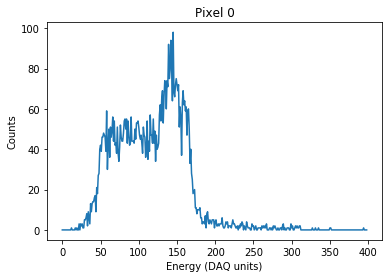

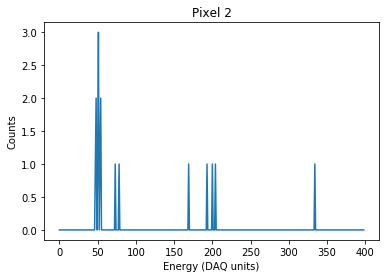

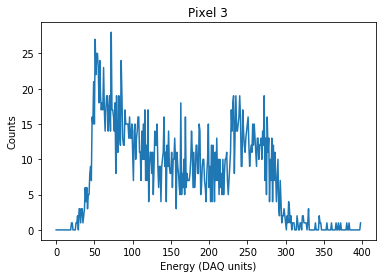

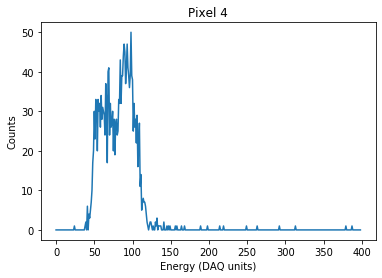

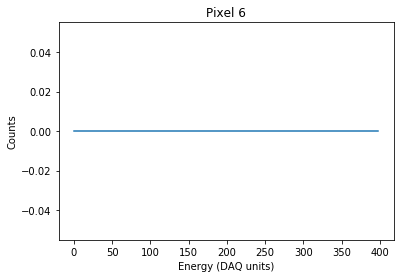

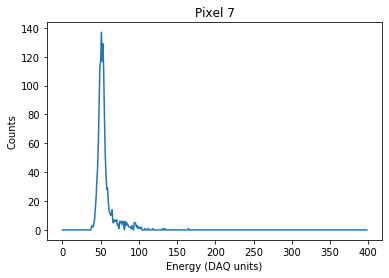

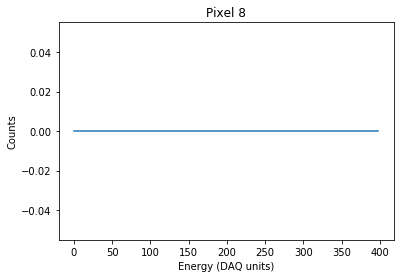

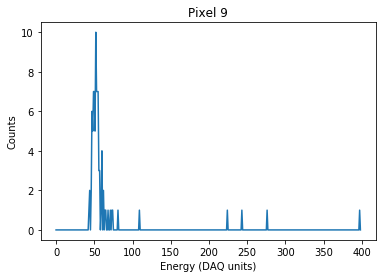

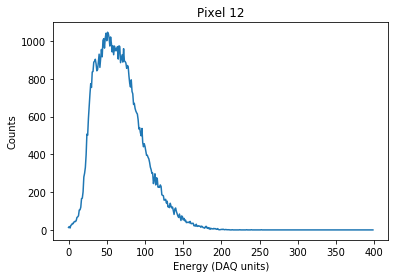

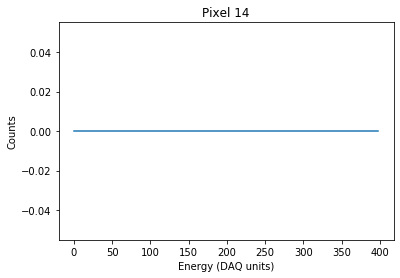

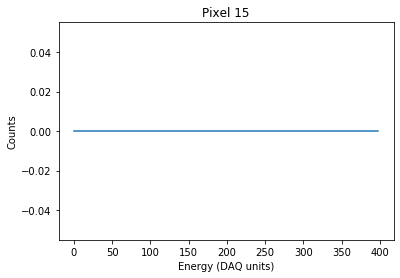

In [39]:
for i in range(len(hists)):
    plt.plot(enerHistBins[:-1], hists[i])
    plt.title('Pixel '+str(i))
    plt.xlabel('Energy (DAQ units)')
    plt.ylabel('Counts')
    plt.savefig('preliminarySpectrum-Pixel'+str(i)+'.png')
    plt.show()

In [43]:
#now go through and make power spectra for each pixel over the whole data set
def doPowerSpectrumAnalysis(files, pixels):
    results = []
    #grab one of them real quick like
    temp = df.dataFile(files[10])
    waves = temp.getPixel(0)
    wave = waves[0]
    temp = 0
    f, Pxx_den = signal.periodogram(wave, 1E8)
    emptyRes = np.zeros(len(Pxx_den))     
    for pixel in pixels:
        print(pixel)
        pixelres = emptyRes[:]
        count = 0
        for f in files:
            data = df.dataFile(f)
            waves = data.getPixel(pixel)
            for wave in waves:
                f, Pxx_den = signal.periodogram(wave, 1E8)
                pixelres = pixelres[:] + Pxx_den[:]
                count += 1
        pixelres = pixelres[:] / count
        results.append(pixelres)
    return f, results                

In [44]:
f, results = doPowerSpectrumAnalysis(files, pixelList)

0
1
2
3
4
5
6
7
8


FileNotFoundError: [Errno 2] No such file or directory: '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/run45176.bin'